In [1]:
from google.cloud import storage
import os
from io import BytesIO
import pandas as pd
import numpy as np

#Connect to GCP bucket and assign the bucket_name and specify the file name
bucket_name = "ychou-bucket1" #Assign the bucket name where your file is stored
storage_client = storage.Client()

bucket = storage_client.get_bucket(bucket_name)

In [2]:
blob = storage.blob.Blob("US_births2018_processed3.csv",bucket)

In [3]:
# Convert to a pandas dataframe
content = blob.download_as_string()
df_processed = pd.read_csv(BytesIO(content))

In [4]:
del content

In [ ]:
#df_processed = df_processed.drop(columns = ['Unnamed: 0', 'MAGE_IMPFLG'])

In [ ]:
#df_processed.columns

In [ ]:
#df_processed = df_processed.drop(columns = ['DLMP_MM','DOB_MM', 'DOB_TT','DOB_WK', 'ILLB_R','ILOP_R','ILP_R',
#                                           'DWgt_R', 'PWgt_R'])

In [ ]:
#df_processed = df_processed.rename(columns={"MRAVE6": "MRACE6"})
#df_processed.head()

In [ ]:
#df_processed['DMAR'].value_counts()

In [5]:
# build model
from pyspark.sql.types import *
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
from pyspark.sql import SparkSession

In [6]:
spark = SparkSession.builder.appName('ml-bank').getOrCreate()

In [7]:
#create spark dataframe
df = spark.createDataFrame(df_processed[:1200000])

In [8]:
del df_processed

In [9]:
df.printSchema()

root
 |-- Unnamed: 0: long (nullable = true)
 |-- ATTEND: long (nullable = true)
 |-- BFACIL: long (nullable = true)
 |-- BMI: double (nullable = true)
 |-- CIG_0: long (nullable = true)
 |-- DBWT: long (nullable = true)
 |-- DMAR: long (nullable = true)
 |-- FAGECOMB: long (nullable = true)
 |-- FEDUC: long (nullable = true)
 |-- FHISPX: long (nullable = true)
 |-- FRACE6: long (nullable = true)
 |-- MAGER: long (nullable = true)
 |-- MBSTATE_REC: long (nullable = true)
 |-- MEDUC: long (nullable = true)
 |-- MHISPX: long (nullable = true)
 |-- MM_AICU: string (nullable = true)
 |-- MRACE6: long (nullable = true)
 |-- M_Ht_In: long (nullable = true)
 |-- NO_INFEC: long (nullable = true)
 |-- NO_MMORB: long (nullable = true)
 |-- NO_RISKS: long (nullable = true)
 |-- PAY_REC: long (nullable = true)
 |-- PRECARE: long (nullable = true)
 |-- PREVIS: long (nullable = true)
 |-- PRIORDEAD: long (nullable = true)
 |-- PRIORLIVE: long (nullable = true)
 |-- PRIORTERM: long (nullable = true)


In [10]:
#Preparing Data for Machine Learning
#merges multiple columns into a vectorcolumn.
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
categoricalColumns = ['ATTEND', 'BFACIL', 'DMAR', 'FEDUC', 'FHISPX', 'FRACE6','MBSTATE_REC','MEDUC',
                      'MHISPX', 'MM_AICU', 'MRACE6', 'NO_INFEC', 'NO_MMORB', 'NO_RISKS', 'PAY_REC',
                      'RDMETH_REC', 'RESTATUS', 'RF_CESARN', 'SEX']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'ANOMALY', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['BMI', 'CIG_0', 'DBWT', 'FAGECOMB', 'MAGER', 'M_Ht_In', 'PRECARE', 'PREVIS', 'PRIORDEAD',
              'PRIORLIVE', 'PRIORTERM', 'RF_CESARN', 'WTGAIN']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [11]:
#chain multiple Transformers and Estimators together to specify our machine learning workflow
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features']
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)



In [12]:
#split train and test
train, test = df.randomSplit([0.7, 0.3], seed = 2020)

In [13]:
del df

In [14]:
pd.DataFrame(train.take(1), columns=train.columns).transpose()

,0
label,0
features,"(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."


In [15]:
from pyspark.sql.functions import col, explode, array, lit
major_train = train.filter(col("label") == 0)
minor_train = train.filter(col("label") == 1)
ratio = int(major_train.count()/minor_train.count())
print("ratio: {}".format(ratio))

ratio: 181


In [16]:
del train

In [36]:
major = train_modified.filter(col("label") == 0)
minor = train_modified.filter(col("label") == 1)
ratio = int(major.count()/minor.count())
print("ratio: {}".format(ratio))

ratio: 1


In [17]:
a = range(ratio)
# duplicate the minority rows
over_train = minor_train.withColumn("dummy", explode(array([lit(x) for x in a]))).drop('dummy')
# combine both oversampled minority rows and previous majority rows 
train_modified = major_train.unionAll(over_train)

In [18]:
del over_train
del major_train

In [19]:
pd.DataFrame(train_modified.take(1), columns=train_modified.columns).transpose()

,0
label,0
features,"(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."


In [20]:
#LogisticRegression
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=5)
lrModel = lr.fit(train_modified)

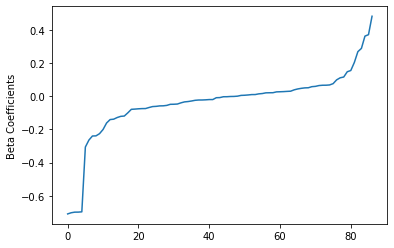

In [21]:
import matplotlib.pyplot as plt
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

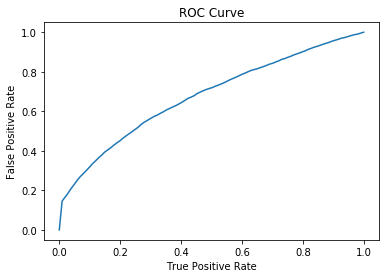

Training set areaUnderROC: 0.6760870917836088


In [22]:
#ROC LogisticRegression
trainingSummary_lr = lrModel.summary
roc = trainingSummary_lr.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary_lr.areaUnderROC))

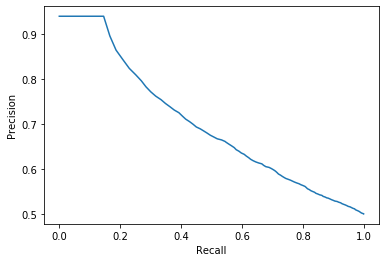

In [23]:
#recall precision LogisticRegression
pr = trainingSummary_lr.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [24]:
#make predictions on test
predictions_lr = lrModel.transform(test)
predictions_lr.select('label', 'rawPrediction', 'prediction', 'probability').show(5)

+-----+--------------------+----------+--------------------+
|label|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+
|  0.0|[0.58211987902208...|       0.0|[0.64155504446119...|
|  0.0|[0.32938861130714...|       0.0|[0.58161060912306...|
|  0.0|[0.55452176962117...|       0.0|[0.63518403842233...|
|  0.0|[0.27249016935798...|       0.0|[0.56770413547664...|
|  0.0|[0.69731964255519...|       0.0|[0.66759323475411...|
+-----+--------------------+----------+--------------------+
only showing top 5 rows



In [25]:
#caculate accuracy precision recall f1
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
evaluator2 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
evaluator3 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
evaluator4 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
accuracy = evaluator1.evaluate(predictions_lr)
precision = evaluator2.evaluate(predictions_lr)
recall = evaluator3.evaluate(predictions_lr)
f1 = evaluator4.evaluate(predictions_lr)
print("Test Accuracy = %g" % (accuracy))
print("Test weightedPrecision = %g" % (precision))
print("Test weightedRecall = %g" % (recall))
print("Test F1 = %g" % (f1))

Test Accuracy = 0.761415
Test weightedPrecision = 0.990881
Test weightedRecall = 0.761415
Test F1 = 0.85947


In [26]:
#evaluate prediction on test
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions_lr))

Test Area Under ROC 0.683865592872157


In [27]:
del lrModel
del predictions_lr

In [29]:
#GBT
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(maxIter=5)
gbtModel = gbt.fit(train_modified)
predictions_gbt = gbtModel.transform(test)
predictions_gbt.select('label', 'rawPrediction', 'prediction', 'probability').show(10)

+-----+--------------------+----------+--------------------+
|label|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+
|  0.0|[0.29043851977393...|       0.0|[0.64126918814554...|
|  0.0|[0.27944455655749...|       0.0|[0.63619546354965...|
|  0.0|[0.29043851977393...|       0.0|[0.64126918814554...|
|  0.0|[-2.4857829362536...|       1.0|[0.49998757108532...|
|  0.0|[0.29043851977393...|       0.0|[0.64126918814554...|
|  0.0|[0.29043851977393...|       0.0|[0.64126918814554...|
|  0.0|[0.24480808605512...|       0.0|[0.62001600813355...|
|  0.0|[0.01506447362563...|       0.0|[0.50753166708003...|
|  0.0|[0.11021146630906...|       0.0|[0.55488369671880...|
|  0.0|[0.01217558545484...|       0.0|[0.50608749191722...|
+-----+--------------------+----------+--------------------+
only showing top 10 rows



In [31]:
#check feature importance
#write a function to better interpret output
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [32]:
ExtractFeatureImp(gbtModel.featureImportances, predictions_gbt, "features").head(10)

,idx,name,score
7,81,PREVIS,0.202034
2,76,DBWT,0.117152
73,60,RESTATUSclassVec_2,0.081735
72,59,RESTATUSclassVec_1,0.077273
4,78,MAGER,0.075905
86,73,SEXclassVec_M,0.051471
6,80,PRECARE,0.043032
9,83,PRIORLIVE,0.035358
58,45,MRACE6classVec_1,0.030582
1,75,CIG_0,0.029791


In [33]:
evaluator1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
evaluator2 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
evaluator3 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
evaluator4 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
accuracy = evaluator1.evaluate(predictions_gbt)
precision = evaluator2.evaluate(predictions_gbt)
recall = evaluator3.evaluate(predictions_gbt)
f1 = evaluator4.evaluate(predictions_gbt)
print("Test Accuracy = %g" % (accuracy))
print("Test weightedPrecision = %g" % (precision))
print("Test weightedRecall = %g" % (recall))
print("Test F1 = %g" % (f1))

Test Accuracy = 0.846071
Test weightedPrecision = 0.991358
Test weightedRecall = 0.846071
Test F1 = 0.911488


In [34]:
#ROC GBT
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions_gbt, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.7340801989711138


In [35]:
del gbtModel
del predictions_gbt

In [ ]:
#from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
#paramGrid = (ParamGridBuilder()
#             .addGrid(gbt.maxDepth, [2, 4, 6])
#             .addGrid(gbt.maxBins, [20, 60])
#             .addGrid(gbt.maxIter, [10, 20])
#             .build())
#cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
# Run cross validations.  This can take about 6 minutes since it is training over 20 trees!
#cvModel = cv.fit(train)
#predictions_cv = cvModel.transform(test)
#evaluator.evaluate(predictions_cv)

In [ ]:
#evaluator1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
#evaluator2 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
#evaluator3 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
#evaluator4 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
#accuracy = evaluator1.evaluate(predictions_cv)
#precision = evaluator2.evaluate(predictions_cv)
#recall = evaluator3.evaluate(predictions_cv)
#f1 = evaluator4.evaluate(predictions_cv)
#print("Test Accuracy = %g" % (accuracy))
#print("Test weightedPrecision = %g" % (precision))
#print("Test weightedRecall = %g" % (recall))
#print("Test F1 = %g" % (f1))